In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import operator

In [44]:
ST_results = pd.read_csv("ST_bydistrict_TGP.csv")
ST_results.head()

,State,Delegates,Biden,Sanders,Bloomberg,Warren,Other,Total
0,AL,11,286067,74867,52750,25847,12784,452315
1,AR,7,92998,51294,38324,22918,23865,229399
2,ME,5,68418,65894,24124,31530,10380,200346
3,MA,20,470448,373221,164538,299700,92138,1397682
4,MN,16,287553,222431,61882,114674,57658,744198


In [36]:
# default values from Morning Consult poll: 
#  https://morningconsult.com/2020/03/05/sanders-biden-can-expect-near-equal-gain-from-warrens-exit/
def split_warren_votes(pre_split_votes = ST_results, warren_to_biden = .36, warren_to_sanders = .43):
    # normalize (assume all EW supporters go either to JB or BS)
    biden_gain = warren_to_biden/(warren_to_biden + warren_to_sanders)
    sanders_gain = warren_to_sanders/(warren_to_biden + warren_to_sanders)
    
    # copy original DF so we don't break anything
    post = pre_split_votes.copy()
    
    # add Warren's votes to Biden and Sanders as needed
    post.Biden = post.Biden + round(biden_gain * post.Warren)
    post.Sanders = post.Sanders + round(sanders_gain * post.Warren)
    post.Warren = 0
    return post

# apportion delegates according to 15% threshold rules
def apportion_delegates_threshold(votes = ST_results, threshold = 0.15):
    delegates = votes.copy()
    delegates = delegates.drop('Other', axis = 1)
    candidates = ['Biden', 'Sanders', 'Warren', 'Bloomberg']
    for c in candidates:
        delegates[c] = delegates[c]/delegates.Total
    delegates[candidates] = delegates[candidates].applymap(lambda x: x if x >= threshold else 0)
    delegates["viable_tot"] = delegates[candidates].sum(axis = 1)
    for c in candidates:
        delegates[c] = (delegates[c]/delegates.viable_tot) * delegates['Delegates']
    # now we apportion fractional delegates as per DNC rules
    dels_copy = delegates.copy()
    for idx, row in dels_copy.iterrows():
        dels_dict = {}
        dels_dict_full = {}
        dels_dict_partial = {}
        for c in candidates:
            dels_dict[c] = row[c]
            dels_dict_full[c] = math.floor(row[c])
            dels_dict_partial[c] = dels_dict[c] - dels_dict_full[c]
        full = sum(dels_dict_full.values())
        fractional = row['Delegates'] - full
        
        # allocate partial delegates
        while fractional > 0:
            top = max(dels_dict_partial.items(), key=operator.itemgetter(1))[0]
            dels_dict_partial[top] = 0
            dels_dict_full[top] += 1
            fractional -= 1
        for c, ds in dels_dict_full.items():
            delegates.at[idx, c] = ds
    return delegates
    

# apportion delegates purely proportionally (just a shortcut)
def apportion_delegates_prop(votes = ST_results):
    return apportion_delegates_threshold(votes = votes, threshold = 0)

# get the biden net delegate gain
def get_biden_net(split, votes = ST_results, threshold = 0.15):
    post_split = split_warren_votes(pre_split_votes = votes, warren_to_biden = split, warren_to_sanders = 1 - split)
    dels = apportion_delegates_threshold(votes = post_split)
    return sum(dels.Biden) - sum(dels.Sanders)

In [45]:
# check process (we want this to end up being 89)
no_change = apportion_delegates_threshold()
tots = no_change.sum()
tots['Biden'] - tots['Sanders']

# note: we get this as 87, we _want_ it to be 89
#  in a more detailed analysis, I would care more about this
#  but this is essentially a rounding error so I'm not super worried

87.0

In [46]:
splits = np.linspace(0,1,101)
net_dels_biden = []
for split in splits:
    net_dels_biden.append(get_biden_net(split))

In [47]:
net_dels_biden_no_threshold = []
for split in splits:
    post_split = split_warren_votes(warren_to_biden = split, warren_to_sanders = 1 - split)
    dels = apportion_delegates_threshold(votes = post_split, threshold = 0)
    net = sum(dels.Biden) - sum(dels.Sanders)
    net_dels_biden_no_threshold.append(net)

In [48]:
# according to the Morning Consult poll
mc_breakequal = .4557
mc_endorse = .36
intersects = [get_biden_net(.4557), get_biden_net(.36)]
print("Net Biden delegates with MC undecideds breaking as decideds: " + str(intersects[0]))
print("Net Biden delegates with MC undecideds breaking Sanders    : " + str(intersects[1]))
ST_actual_net = 89

Net Biden delegates with MC undecideds breaking as decideds: 50.0
Net Biden delegates with MC undecideds breaking Sanders    : 12.0


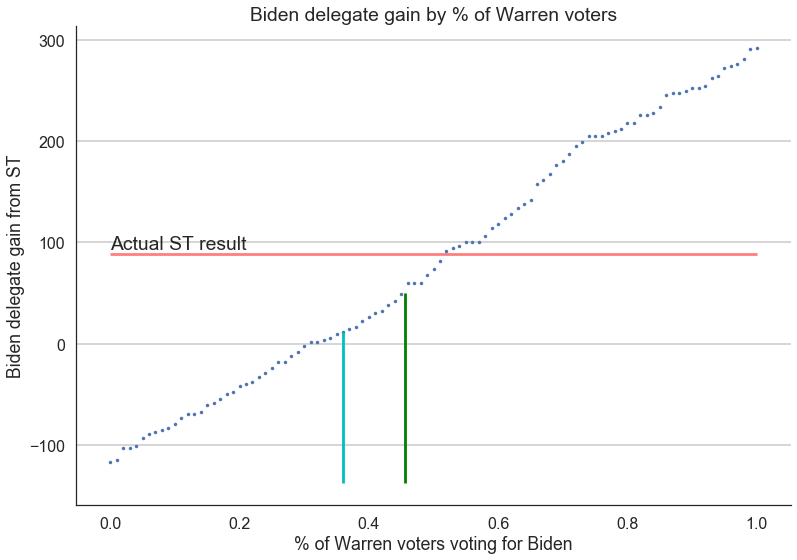

In [55]:
with sns.plotting_context("poster"):
    sns.set_style('white')
    plt.scatter(splits, net_dels_biden, s = 9)
    plt.ylabel("Biden delegate gain from ST")
    plt.xlabel("% of Warren voters voting for Biden")
    plt.hlines(ST_actual_net, 0, 1, color = 'red', alpha = 0.5, label = 'Actual ST result')
    plt.text(0, ST_actual_net + 4, "Actual ST result")
    plt.vlines([mc_breakequal, mc_endorse], plt.ylim()[0], intersects, color = ['g', 'c'])
    plt.grid(which = 'major', axis = 'y')
    plt.title("Biden delegate gain by % of Warren voters")
    sns.despine()
    plt.savefig("dnc_threshold.png")
    plt.show()

In [56]:
# find out pct of Warren vote Sanders would have needed 
#  to keep Biden gain to X number of delegates
def warren_votes_needed(X, dels = net_dels_biden, pct = splits):
    for i in range(len(net_dels_biden)):
        if dels[i] > X:
            return pct[i-1]
    return None

In [57]:
print("Portion of Warren voters Sanders needed to WIN Super Tuesday delegates: " + str(warren_votes_needed(0)))
print("Portion of Warren voters Sanders needed to lead after Super Tuesday   : " + str(warren_votes_needed(7)))

Portion of Warren voters Sanders needed to WIN Super Tuesday delegates: 0.3
Portion of Warren voters Sanders needed to lead after Super Tuesday   : 0.34
